In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import cftime

def calculate_gdd(data, baseline=6, max_threshold=28):
    """Calculate Growing Degree Days (GDD) with specified baseline and max threshold."""
    # Calculate daily GDD ensuring the data does not exceed the max threshold and is above the baseline
    gdd = np.where(data > baseline, np.minimum(data, max_threshold) - baseline, 0)
    # Sum over the 'time' dimension to get total GDD
    return gdd.sum(axis=0)

def filter_months(data, start_month=1, end_month=9):
    """Filter data to include only the months from January to September."""
    # Filter based on the month of the time coordinate
    return data.sel(time=data.time.dt.month.isin(range(start_month, end_month + 1)))


In [2]:
def process_file(file_path, period):
    """Process a single NetCDF file to calculate GDD for a specified climatology period."""
    # Load the dataset
    ds = xr.open_dataset(file_path, use_cftime=True)
    # Convert TREFHT from Kelvin to Celsius
    trefht_celsius = ds['TREFHT'] - 273.15
    
    # Adjust longitude range for CONUS and filter by months January-September
    conus_data = trefht_celsius.sel(lon=slice(235, 295), lat=slice(25, 50))
    conus_data = filter_months(conus_data)
    
    # Select data for the specified period
    if period == '1991-2020':
        period_data = conus_data.sel(time=slice(cftime.DatetimeNoLeap(1991, 1, 1), cftime.DatetimeNoLeap(2020, 12, 31)))
    elif period == '2031-2060':
        period_data = conus_data.sel(time=slice(cftime.DatetimeNoLeap(2031, 1, 1), cftime.DatetimeNoLeap(2060, 12, 31)))
    else:
        raise ValueError(f"Invalid period specified: {period}")

    # Calculate GDD
    gdd = calculate_gdd(period_data)
    
    return gdd


In [3]:
# Path to the .nc files
nc_files_directory = '/data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/*.nc'
nc_files = glob.glob(nc_files_directory)
nc_files.sort()

# Process files for the first climatology period (1991-2020)
gdd_1991_2020_results = []
for file_path in nc_files:
    gdd = process_file(file_path, '1991-2020')
    gdd_1991_2020_results.append(gdd)


In [71]:
print("Number of Files Processed:", len(nc_files))
# Print the shape of gdd_1991_2020_results before calculating the ensemble mean
print("Shape of gdd_1991_2020_results before calculating ensemble mean:", np.shape(gdd_1991_2020_results))


Number of Files Processed: 50
Shape of gdd_1991_2020_results before calculating ensemble mean: (50, 26, 49)


In [69]:
# Calculate ensemble mean
ensemble_mean = np.mean(gdd_1991_2020_results, axis=0) / 30

print("Ensemble Mean Array:\n", ensemble_mean)
print("Ensemble Mean Array Shape:", ensemble_mean.shape)


Ensemble Mean Array:
 [[3449.874   3440.6392  3445.896   ... 5138.816   5124.795   5111.71   ]
 [3320.384   3304.9854  3303.8953  ... 5048.017   5034.5747  5022.338  ]
 [3200.0093  3182.0737  3179.0781  ... 4953.38    4939.7886  4927.787  ]
 ...
 [1582.2046  1677.4929  1667.4064  ... 1370.6198  1377.9532  1299.4633 ]
 [1525.8322  1672.3395  1660.9968  ... 1270.409   1223.9019  1206.918  ]
 [1573.0962  1594.0957  1440.7198  ...  845.73254  687.00366  689.43286]]
Ensemble Mean Array Shape: (26, 49)


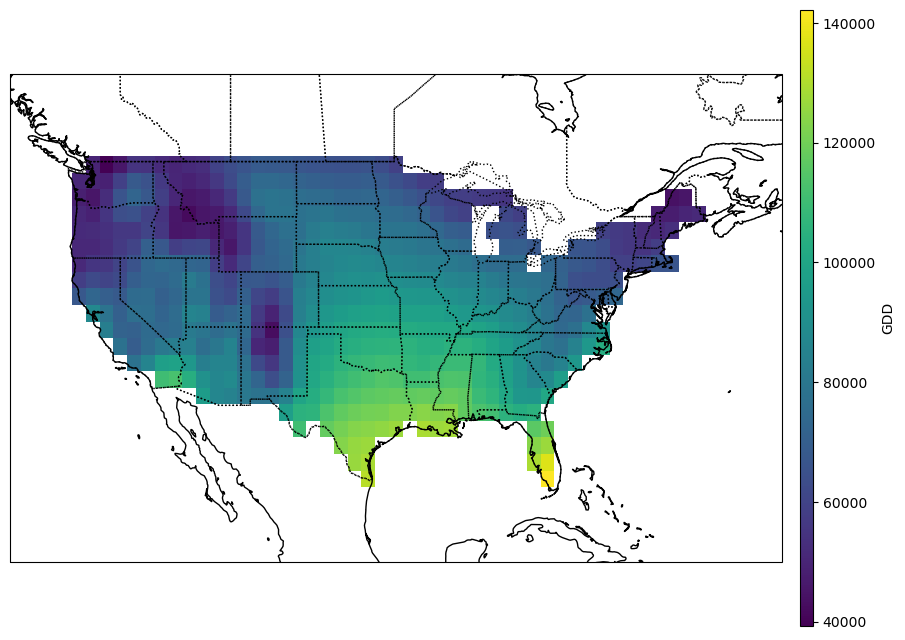

In [19]:
import geopandas as gpd
import regionmask
import numpy as np
import cartopy.feature as cfeature
import xarray as xr

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Make sure the longitude and latitude from your GDD data are 1D arrays that span the data's extent
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = np.linspace(235, 295, gdd.shape[1])  # Replace with your GDD data's longitude range
lat_1d = np.linspace(20, 50, gdd.shape[0])     # Replace with your GDD data's latitude range

# Use regionmask to create a mask for the GDD data array
mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)
# Apply the mask to your GDD data
gdd_masked = np.where(mask == 0, gdd, np.nan)  # Assuming land is marked as '0' in your shapefile


import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-130, -60, 20, 50])  # CONUS extent

# Plot the shapefile as the base layer
gdf.plot(ax=ax, facecolor='lightgray', edgecolor='black')

# Plot the masked GDD data over the shapefile
# Assuming you have longitude and latitude arrays that match the shape of gdd_masked
cf = ax.pcolormesh(lon_1d, lat_1d, gdd_masked, transform=ccrs.PlateCarree(), cmap='viridis')

# Add coastlines and other features for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add a colorbar
cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('GDD')

plt.show()


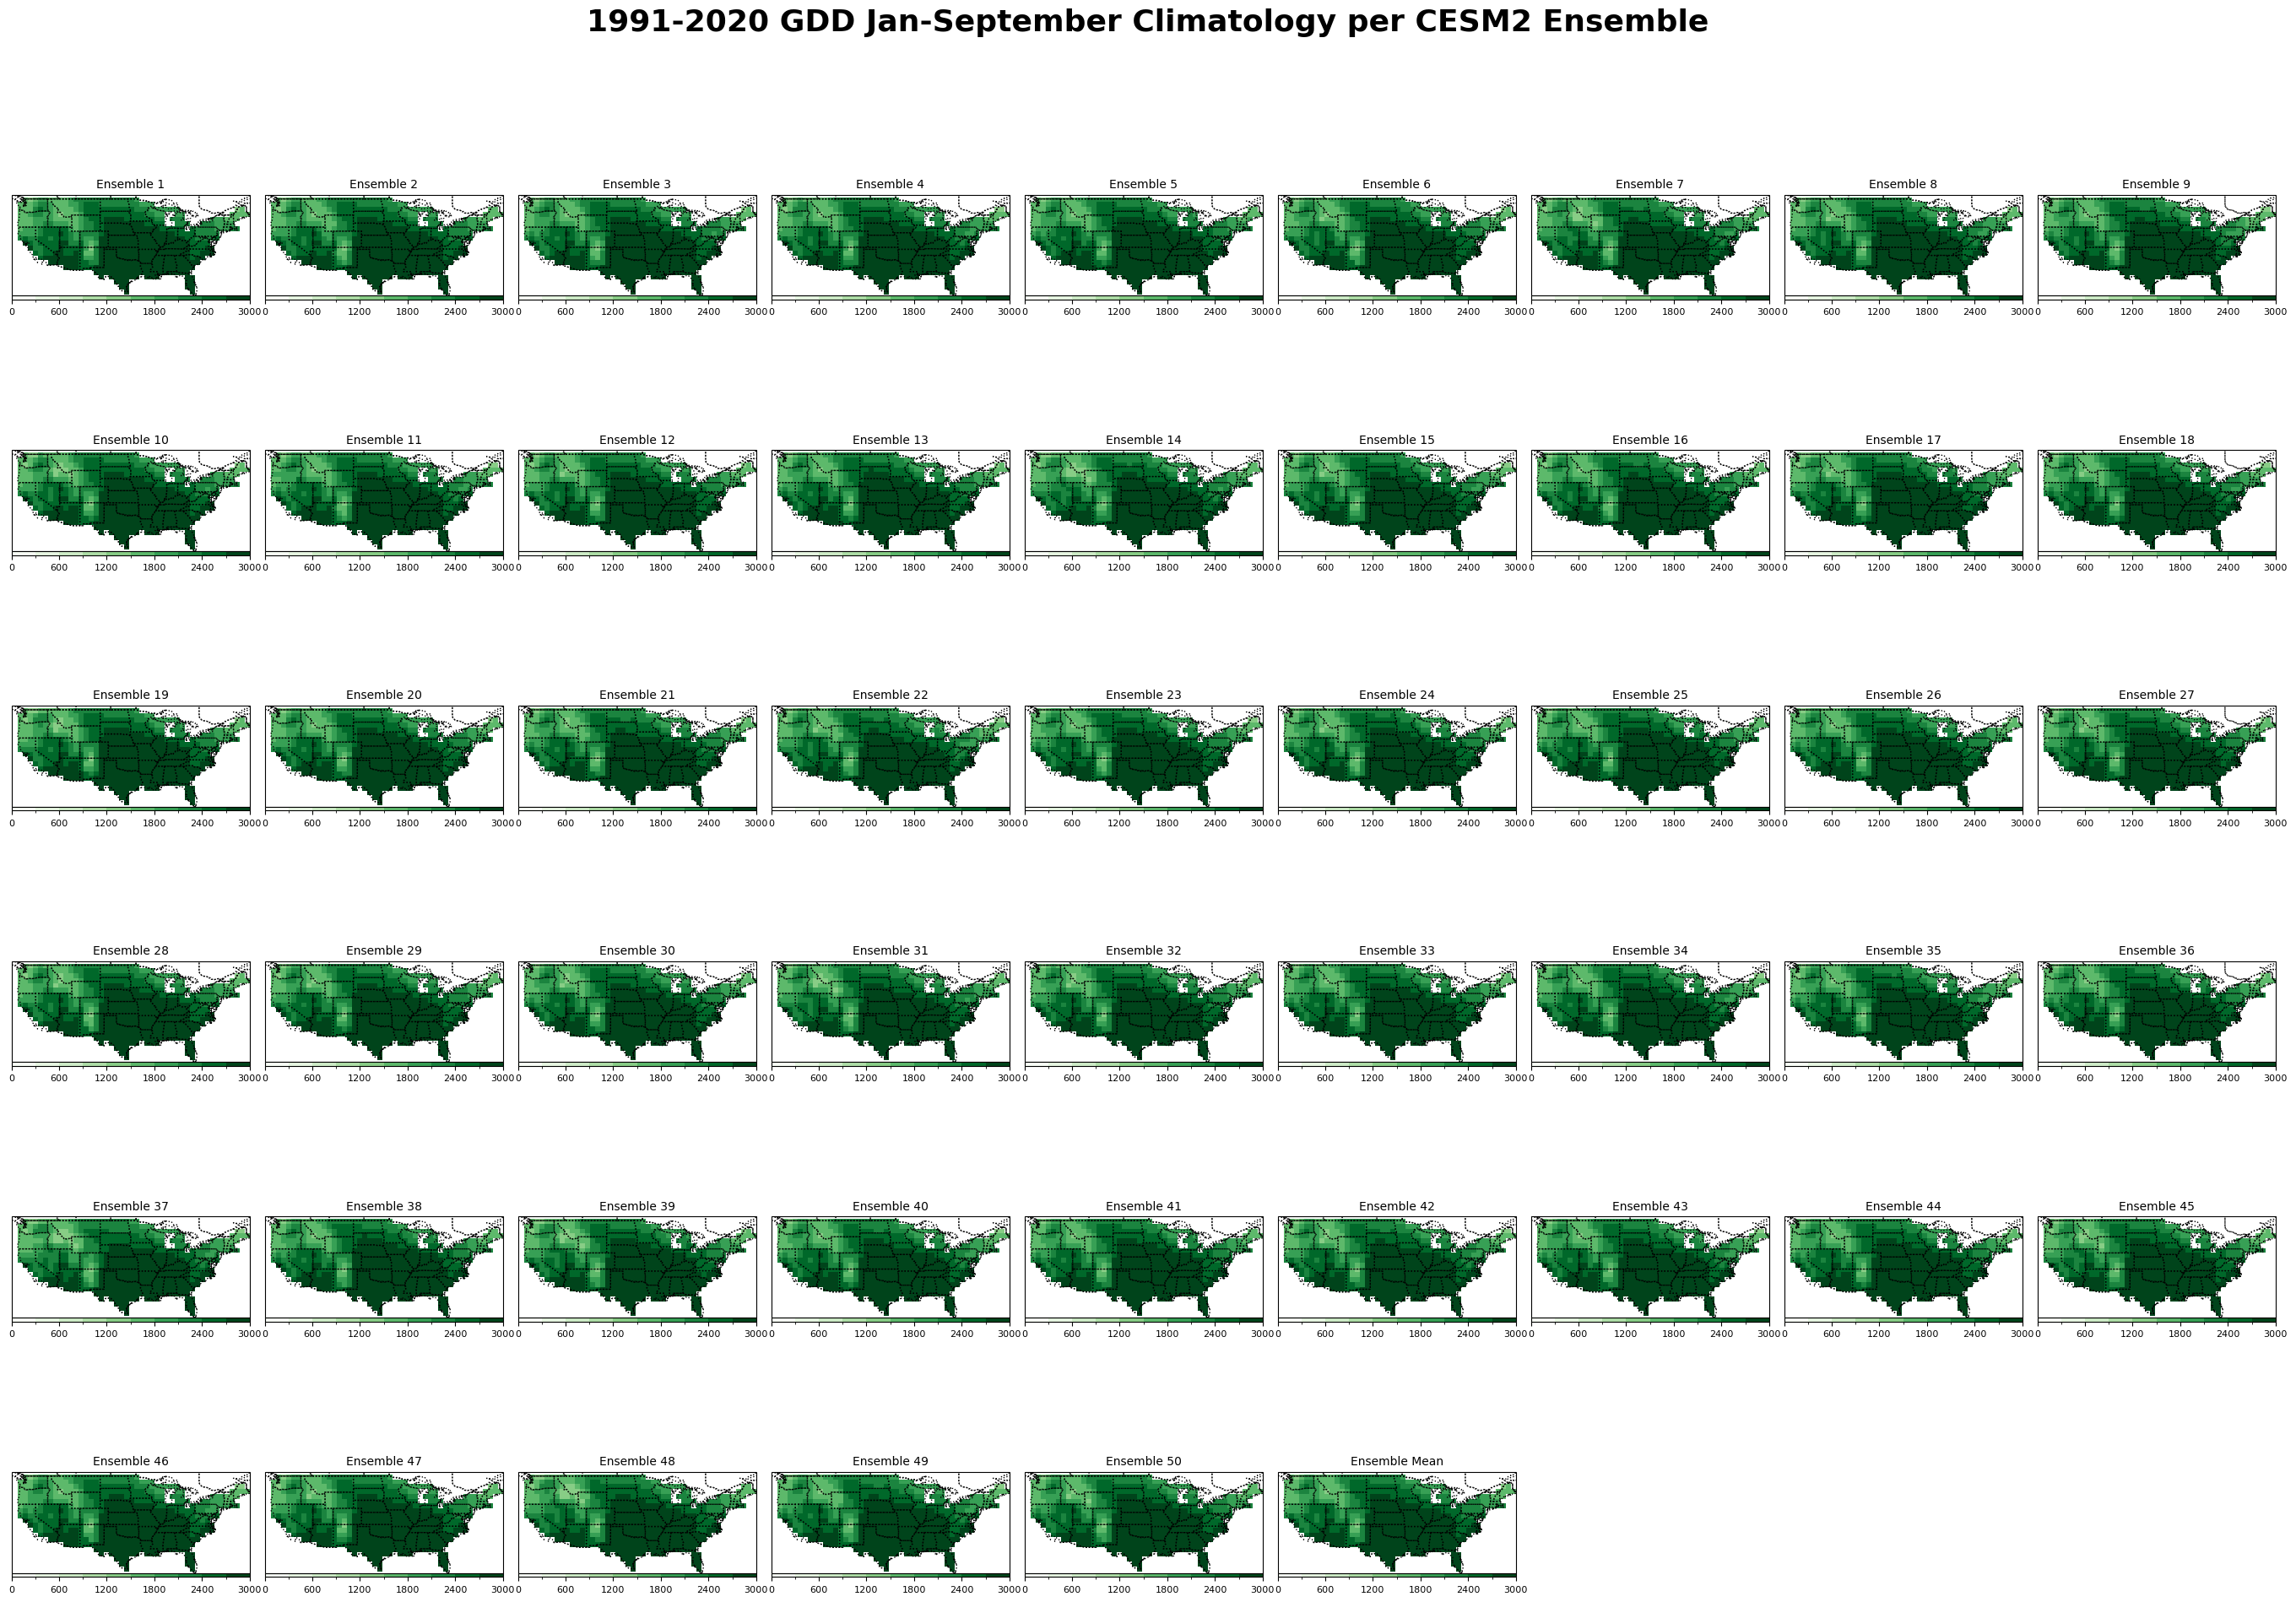

In [77]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import regionmask
import numpy as np
import cartopy.feature as cfeature
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
import matplotlib.ticker as ticker

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)


# Number of rows and columns for the subplots
nrows, ncols = 6, 9  # 50 ensembles in total

# Determine the figure size dynamically based on the number of rows and columns
fig_width = ncols * 3  # Each subplot will be 3 inches wide
fig_height = nrows * 3.2  # Each subplot will be 3.2 inches tall, including space for colorbar

# Initialize the figure and axes for the stamp maps
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Define the boundaries for the discrete intervals
boundaries = np.arange(0, 3001, 300)  # These are the edges of the intervals
# Determine the tick positions for the colorbar
ticks = np.arange(0, 3001, 600)

# Create a color map and norm object
cmap = plt.get_cmap('Greens', len(boundaries) - 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Iterate over each ensemble member
for i, ax in enumerate(axes[:50]):  # Exclude the last axis for the ensemble mean
    ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')

    # Ensemble members plotting
    if i < len(gdd_1991_2020_results):
        gdd_total = gdd_1991_2020_results[i]
        gdd_masked_total = np.where(mask == 0, gdd_total, np.nan)
        gdd_average = gdd_masked_total / 30

        pcm = ax.pcolormesh(lon_1d, lat_1d, gdd_average, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
        cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
        cbar.ax.tick_params(labelsize=8)
        ax.set_title(f'Ensemble {i + 1}', fontsize=10)

# Plot the ensemble mean on the 51st axis
ensemble_mean_ax = axes[50]
ensemble_mean_ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
ensemble_mean_ax.add_feature(cfeature.BORDERS, linestyle=':')
ensemble_mean_ax.add_feature(cfeature.STATES, linestyle=':')
gdd_masked_mean = np.where(mask == 0, ensemble_mean, np.nan)
pcm_mean = ensemble_mean_ax.pcolormesh(lon_1d, lat_1d, gdd_masked_mean, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ensemble_mean_ax.set_title('Ensemble Mean', fontsize=10)
cbar_mean = fig.colorbar(pcm_mean, ax=ensemble_mean_ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
cbar_mean.ax.tick_params(labelsize=8)

# Hide any remaining axes
for ax in axes[51:]:
    ax.set_visible(False)

# Adjust spacing between subplots and between subplots and colorbar
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(top=0.95)
plt.suptitle('1991-2020 GDD Jan-September Climatology per CESM2 Ensemble', fontsize=26, fontweight = 'bold', y = 0.99)
plt.show()


In [92]:
# Path to the .nc files
nc_files_directory = '/data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/*.nc'
nc_files = glob.glob(nc_files_directory)
nc_files.sort()

# Process files for the first climatology period (1991-2020)
gdd_2031_2060_results = []
for file_path in nc_files:
    gdd = process_file(file_path, '2031-2060')
    gdd_2031_2060_results.append(gdd)
# Calculate ensemble mean
ensemble_mean_2031_2060 = np.mean(gdd_2031_2060_results, axis=0) / 30


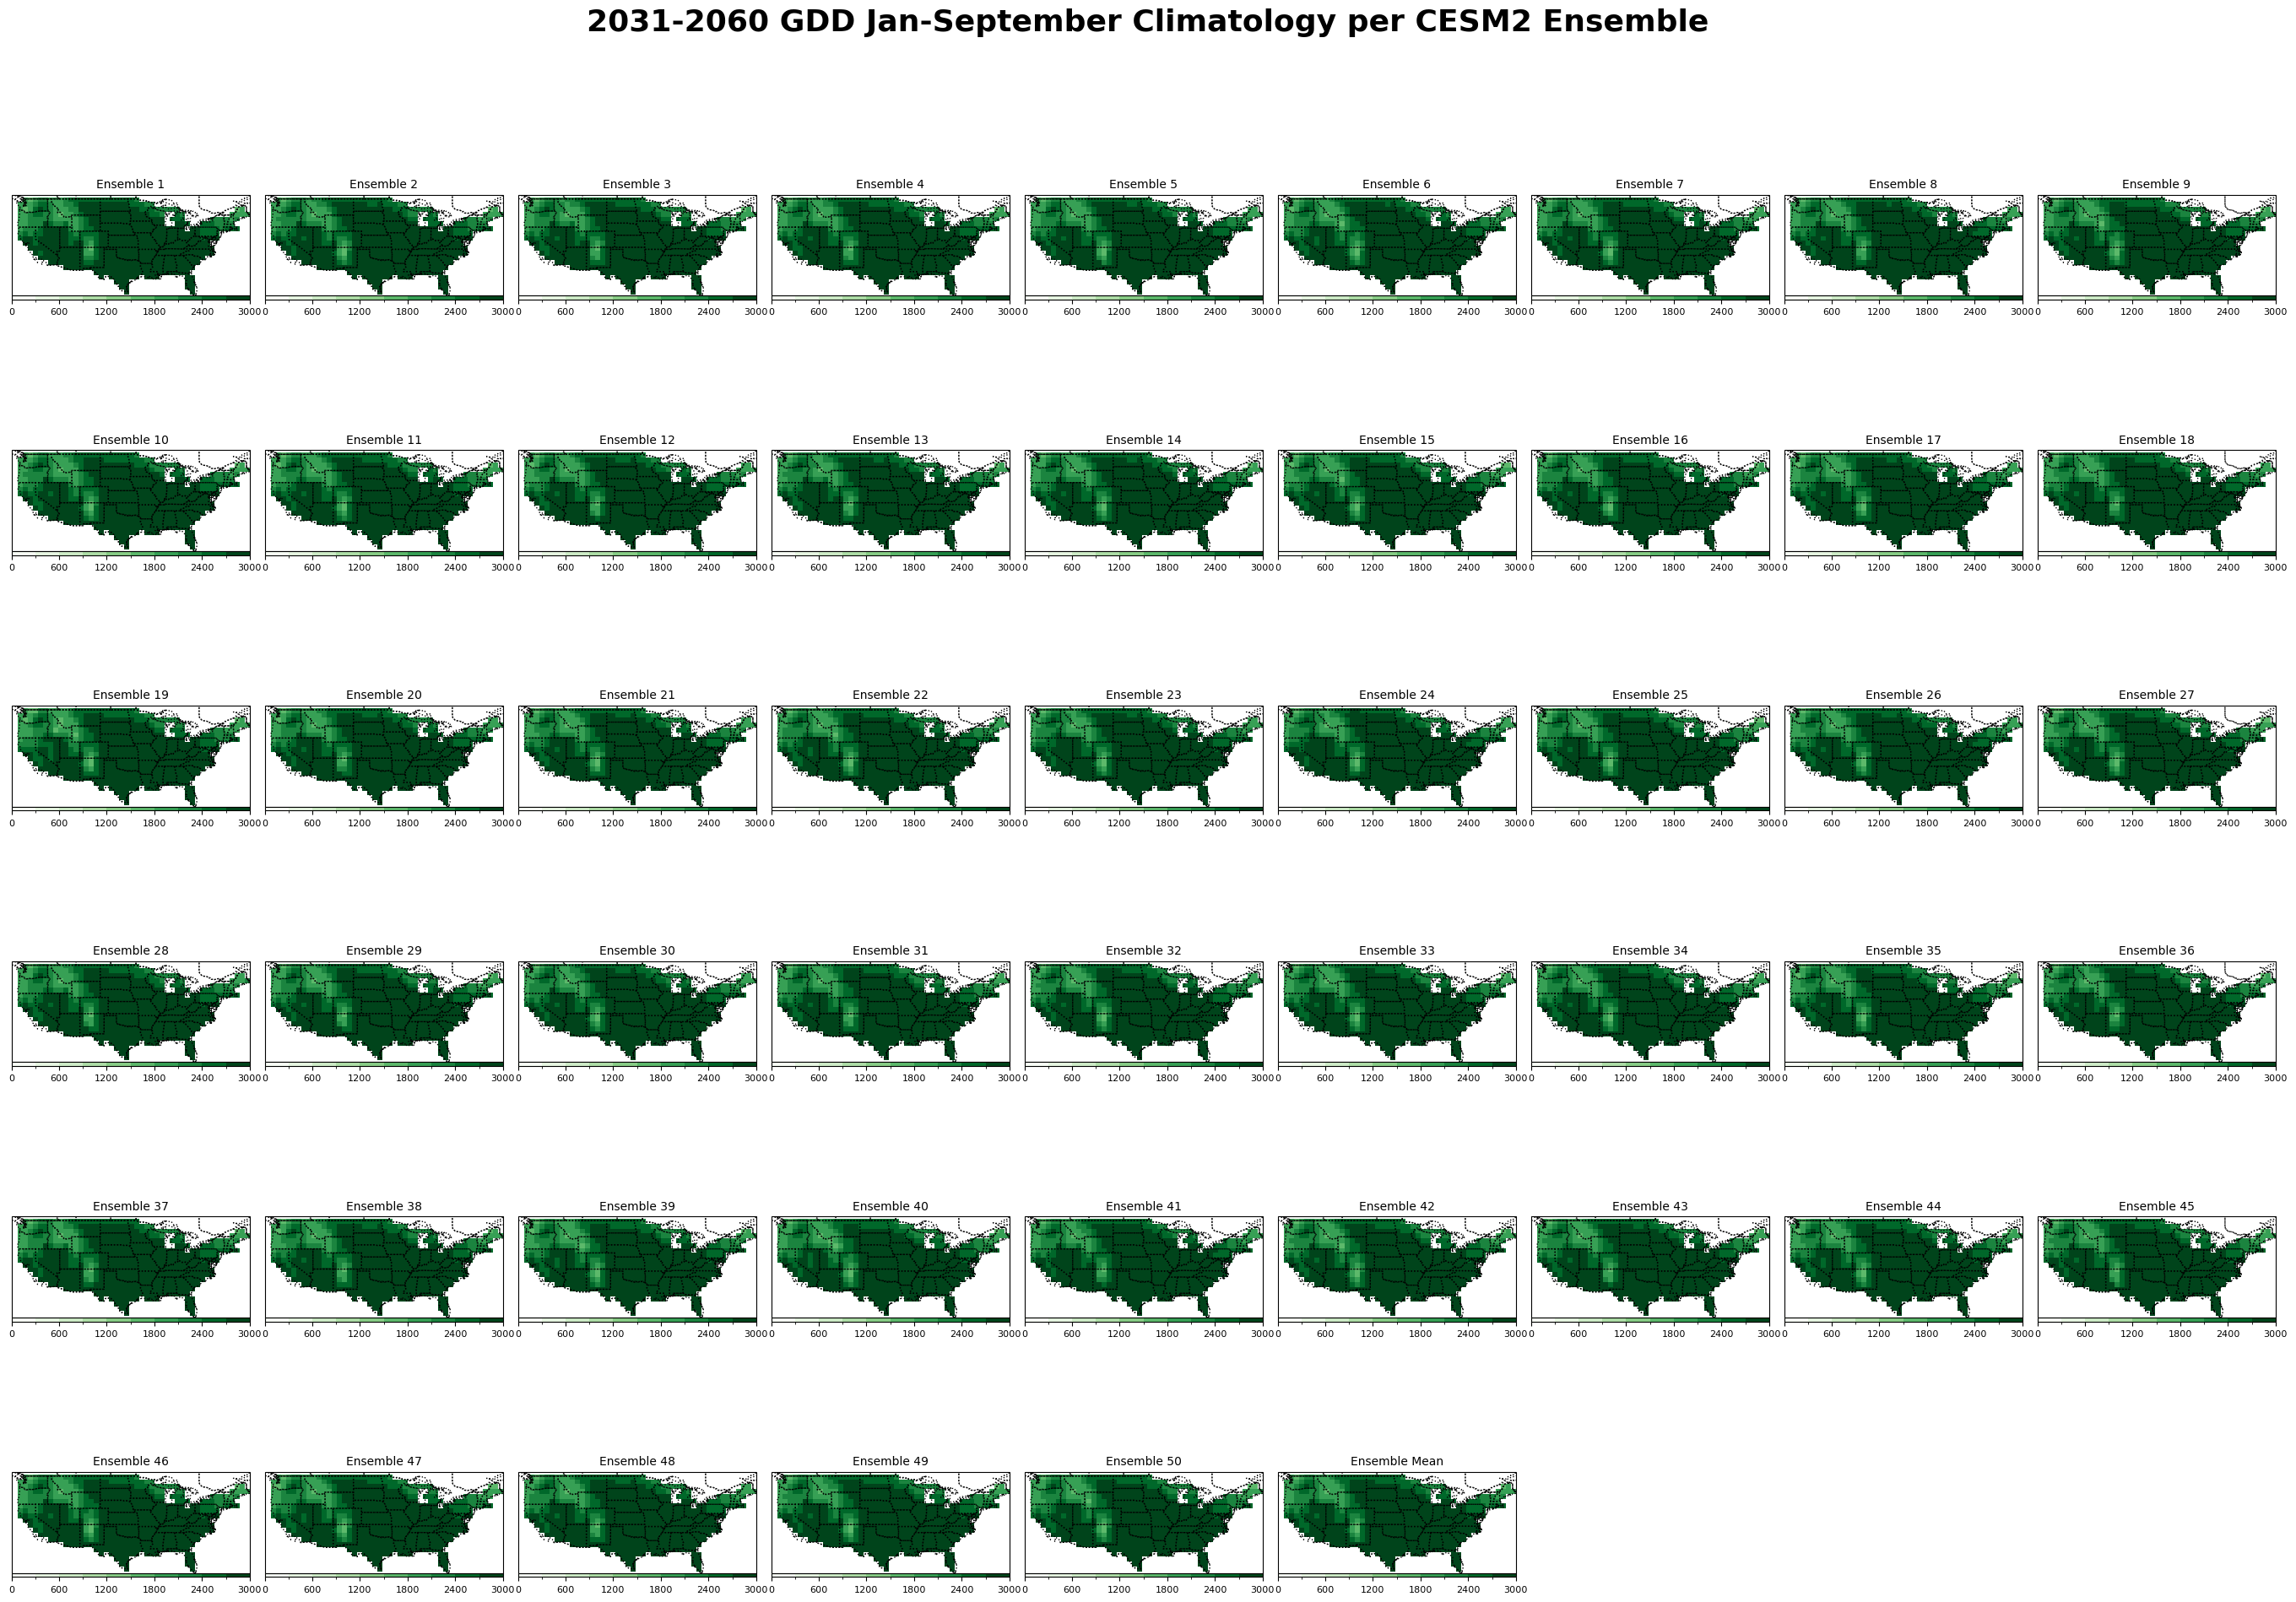

In [93]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import regionmask
import numpy as np
import cartopy.feature as cfeature
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
import matplotlib.ticker as ticker

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)


# Number of rows and columns for the subplots
nrows, ncols = 6, 9  # 50 ensembles in total

# Determine the figure size dynamically based on the number of rows and columns
fig_width = ncols * 3  # Each subplot will be 3 inches wide
fig_height = nrows * 3.2  # Each subplot will be 3.2 inches tall, including space for colorbar

# Initialize the figure and axes for the stamp maps
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Define the boundaries for the discrete intervals
boundaries = np.arange(0, 3001, 300)  # These are the edges of the intervals
# Determine the tick positions for the colorbar
ticks = np.arange(0, 3001, 600)

# Create a color map and norm object
cmap = plt.get_cmap('Greens', len(boundaries) - 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Iterate over each ensemble member
for i, ax in enumerate(axes[:50]):  # Exclude the last axis for the ensemble mean
    ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')

    # Ensemble members plotting
    if i < len(gdd_2031_2060_results):
        gdd_total = gdd_2031_2060_results[i]
        gdd_masked_total = np.where(mask == 0, gdd_total, np.nan)
        gdd_average = gdd_masked_total / 30

        pcm = ax.pcolormesh(lon_1d, lat_1d, gdd_average, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
        cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
        cbar.ax.tick_params(labelsize=8)
        ax.set_title(f'Ensemble {i + 1}', fontsize=10)

# Plot the ensemble mean on the 51st axis
ensemble_mean_2031_2060_ax = axes[50]
ensemble_mean_2031_2060_ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
ensemble_mean_2031_2060_ax.add_feature(cfeature.BORDERS, linestyle=':')
ensemble_mean_2031_2060_ax.add_feature(cfeature.STATES, linestyle=':')
gdd_masked_mean_2031_2060 = np.where(mask == 0, ensemble_mean_2031_2060, np.nan)
pcm_mean_2031_2060_ = ensemble_mean_2031_2060_ax.pcolormesh(lon_1d, lat_1d, gdd_masked_mean_2031_2060, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ensemble_mean_2031_2060_ax.set_title('Ensemble Mean', fontsize=10)
cbar_mean = fig.colorbar(pcm_mean_2031_2060_, ax=ensemble_mean_2031_2060_ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
cbar_mean.ax.tick_params(labelsize=8)

# Hide any remaining axes
for ax in axes[51:]:
    ax.set_visible(False)

# Adjust spacing between subplots and between subplots and colorbar
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(top=0.95)
plt.suptitle('2031-2060 GDD Jan-September Climatology per CESM2 Ensemble', fontsize=26, fontweight = 'bold', y = 0.99)
plt.show()


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import regionmask
import numpy as np
import cartopy.feature as cfeature
import matplotlib as mpl

# Assuming you have loaded the gdf and mask as before

# Calculate the change (delta GDD) for each ensemble member
delta_gdd_ensemble_members = [gdd_2031_2060 - gdd_1991_2020 for gdd_1991_2020, gdd_2031_2060 in zip(gdd_1991_2020_results, gdd_2031_2060_results)]

# Calculate the change (delta GDD) for the ensemble mean
delta_gdd_ensemble_mean = ensemble_mean_2031_2060 - ensemble_mean

# Define the boundaries for the discrete intervals for the delta
boundaries = np.linspace(-500, 501, 11)  # Example boundaries for delta GDD
ticks = np.arange(-500, 501, 100)  # Example ticks for delta GDD

# Create a diverging color map for the delta GDD
cmap = plt.get_cmap('RdBu_r', len(boundaries) - 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
# Define the boundaries for the discrete intervals for the delta of the ensemble mean
mean_boundaries = np.linspace(-500, 501, 11)  # Smaller range for ensemble mean delta GDD
mean_ticks = np.arange(-500, 501, 100)  # Fewer ticks for ensemble mean delta GDD

# Create a color map and norm object for the ensemble members
member_cmap = plt.get_cmap('RdBu_r', len(mean_boundaries) - 1)
member_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

# Create a norm object for the ensemble mean
mean_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

# Plotting the change for each ensemble member and the ensemble mean
nrows, ncols = 6, 9
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3.2), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, ax in enumerate(axes[:50]):
    ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    
    delta_gdd = delta_gdd_ensemble_members[i] / 30
    delta_gdd_masked = np.where(mask == 0, delta_gdd, np.nan)
    
    pcm = ax.pcolormesh(lon_1d, lat_1d, delta_gdd_masked, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f'Ensemble {i + 1}', fontsize=12, fontweight = 'bold')

# Plot the ensemble mean change on the 51st axis with its unique boundaries and ticks
ensemble_mean_change_ax = axes[50]
ensemble_mean_change_ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
ensemble_mean_change_ax.add_feature(cfeature.BORDERS, linestyle=':')
ensemble_mean_change_ax.add_feature(cfeature.STATES, linestyle=':')
delta_gdd_mean_masked = np.where(mask == 0, delta_gdd_ensemble_mean, np.nan)

pcm_mean = ensemble_mean_change_ax.pcolormesh(lon_1d, lat_1d, delta_gdd_mean_masked, transform=ccrs.PlateCarree(), cmap=member_cmap, norm=mean_norm)
ensemble_mean_change_ax.set_title('Change Ensemble Mean', fontsize=12, fontweight = 'bold')

# Create the colorbar for the ensemble mean with its unique boundaries and ticks
cbar_mean = fig.colorbar(pcm_mean, ax=ensemble_mean_change_ax, orientation='horizontal', pad=1, aspect=60, shrink=1, boundaries=mean_boundaries, ticks=mean_ticks)
cbar_mean.ax.tick_params(labelsize=8)

# Hide any remaining axes
for ax in axes[51:]:
    ax.set_visible(False)

plt.tight_layout(pad=0, w_pad=0.125, h_pad=0)
plt.subplots_adjust(top=0.95)
plt.suptitle('Change in GDD Jan-September Climatology per CESM2 Ensemble/Mean (2031-2060 minus 1991-2020)', fontsize=16, fontweight='bold', y=0.92)
plt.savefig('gdddiffernce_1991_2020_2031_2060.png', dpi = 300, bbox_inches = 'tight')
plt.show()


NameError: name 'gdd_1991_2020_results' is not defined

# Using the .nc files

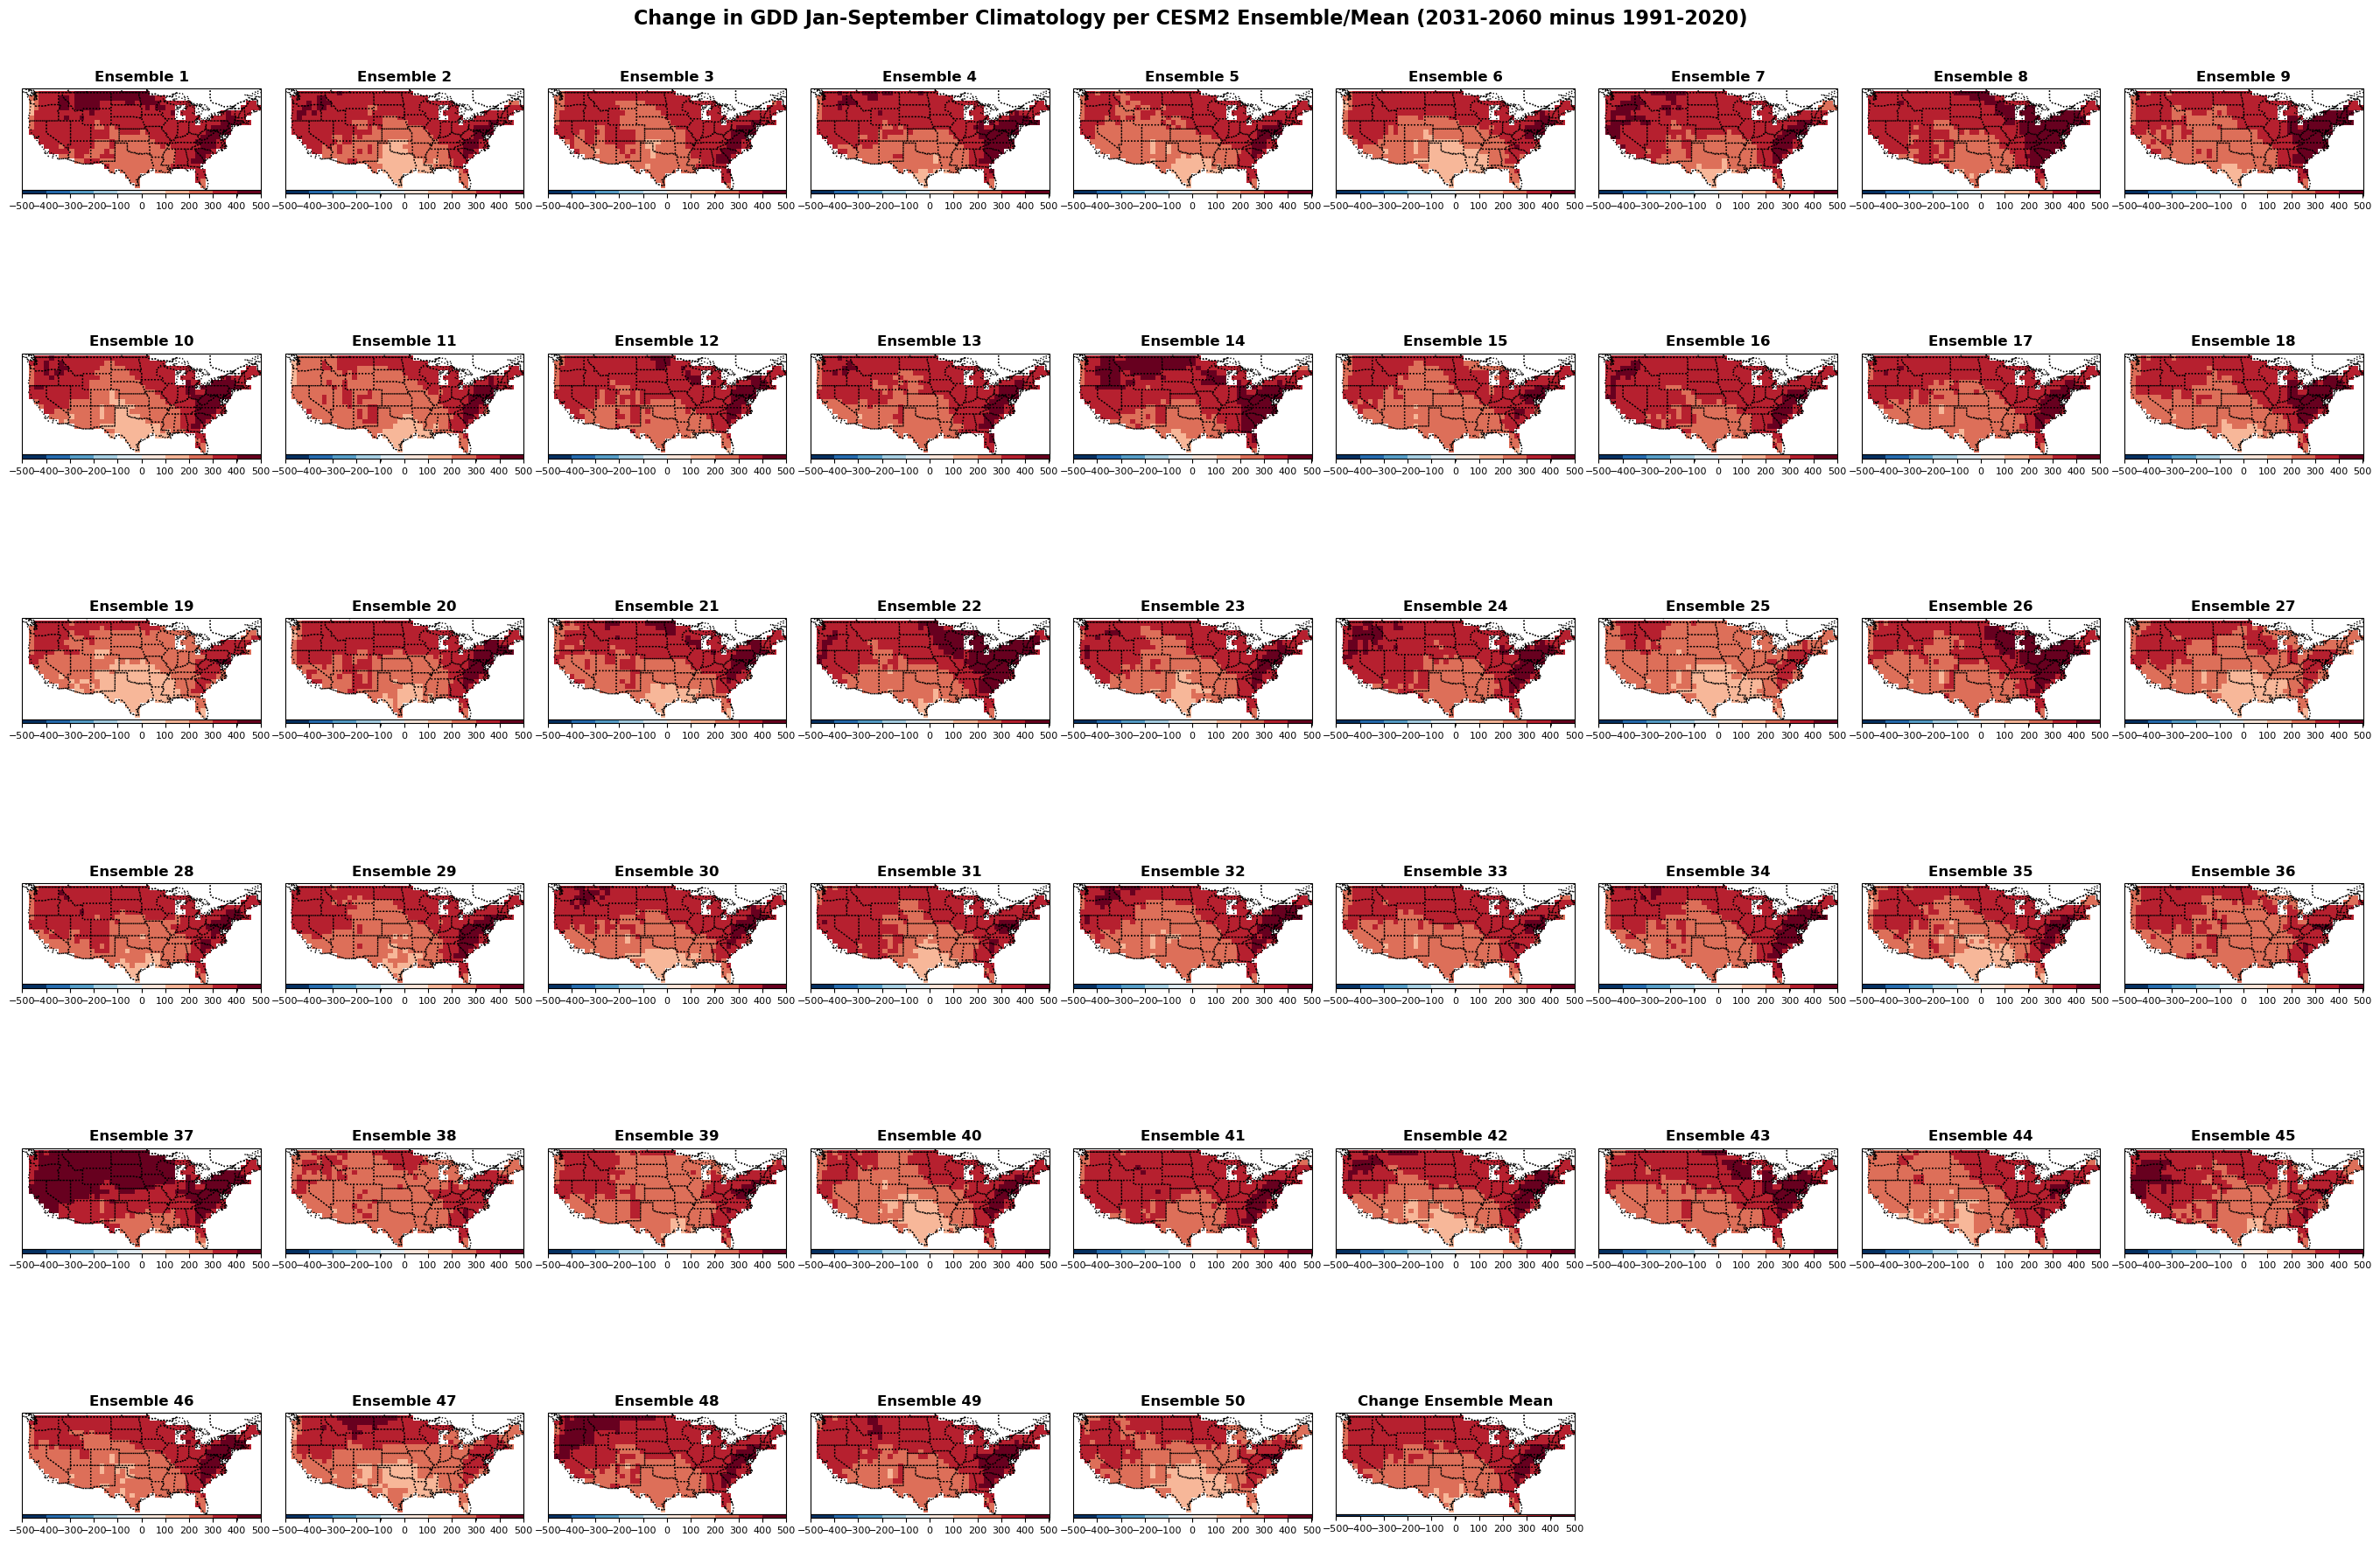

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import matplotlib as mpl
import xarray as xr
# Load the data from NetCDF files
ds_1991_2020 = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/GDD_1991_2020.nc')
ds_2031_2060 = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/GDD_2031_2060.nc')


# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = ds_1991_2020['lon'].values  # Use .values to get a numpy array
lat_1d = ds_1991_2020['lat'].values

mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)


# Extract the GDD values for each ensemble member
gdd_1991_2020_ensemble = ds_1991_2020['gdd_ensemble_1991_2020']
gdd_2031_2060_ensemble = ds_2031_2060['gdd_ensemble_2031_2060']  
# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = ds_1991_2020['lon'].values  # Use .values to get a numpy array
lat_1d = ds_1991_2020['lat'].values

# Calculate the change (delta GDD) for each ensemble member
delta_gdd_ensemble_members = gdd_2031_2060_ensemble - gdd_1991_2020_ensemble

# Extract the ensemble mean GDD values
ensemble_mean_1991_2020 = ds_1991_2020['gdd_ensemble_mean_1991_2020']
ensemble_mean_2031_2060 = ds_2031_2060['gdd_ensemble_mean_2031_2060'] 

# Calculate the change (delta GDD) for the ensemble mean
delta_gdd_ensemble_mean = ensemble_mean_2031_2060 - ensemble_mean_1991_2020

# Define the boundaries for the discrete intervals for the delta
boundaries = np.linspace(-500, 501, 11)  # Example boundaries for delta GDD
ticks = np.arange(-500, 501, 100)  # Example ticks for delta GDD

# Create a diverging color map for the delta GDD
cmap = plt.get_cmap('RdBu_r', len(boundaries) - 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
# Define the boundaries for the discrete intervals for the delta of the ensemble mean
mean_boundaries = np.linspace(-500, 501, 11)  # Smaller range for ensemble mean delta GDD
mean_ticks = np.arange(-500, 501, 100)  # Fewer ticks for ensemble mean delta GDD

# Create a color map and norm object for the ensemble members
member_cmap = plt.get_cmap('RdBu_r', len(mean_boundaries) - 1)
member_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

# Create a norm object for the ensemble mean
mean_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

# Plotting the change for each ensemble member and the ensemble mean
nrows, ncols = 6, 9
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3.2), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, ax in enumerate(axes[:50]):
    ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    
    delta_gdd = delta_gdd_ensemble_members[i] / 30
    delta_gdd_masked = np.where(mask == 0, delta_gdd, np.nan)
    
    pcm = ax.pcolormesh(lon_1d, lat_1d, delta_gdd_masked, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f'Ensemble {i + 1}', fontsize=12, fontweight = 'bold')

# Plot the ensemble mean change on the 51st axis with its unique boundaries and ticks
ensemble_mean_change_ax = axes[50]
ensemble_mean_change_ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
ensemble_mean_change_ax.add_feature(cfeature.BORDERS, linestyle=':')
ensemble_mean_change_ax.add_feature(cfeature.STATES, linestyle=':')
delta_gdd_mean_masked = np.where(mask == 0, delta_gdd_ensemble_mean, np.nan)

pcm_mean = ensemble_mean_change_ax.pcolormesh(lon_1d, lat_1d, delta_gdd_mean_masked, transform=ccrs.PlateCarree(), cmap=member_cmap, norm=mean_norm)
ensemble_mean_change_ax.set_title('Change Ensemble Mean', fontsize=12, fontweight = 'bold')

# Create the colorbar for the ensemble mean with its unique boundaries and ticks
cbar_mean = fig.colorbar(pcm_mean, ax=ensemble_mean_change_ax, orientation='horizontal', pad=0, aspect=100, shrink=1, boundaries=mean_boundaries, ticks=mean_ticks)
cbar_mean.ax.tick_params(labelsize=8)

# Hide any remaining axes
for ax in axes[51:]:
    ax.set_visible(False)

plt.tight_layout(pad=0, w_pad=0.125, h_pad=0)
plt.subplots_adjust(top=0.95)
plt.suptitle('Change in GDD Jan-September Climatology per CESM2 Ensemble/Mean (2031-2060 minus 1991-2020)', fontsize=16, fontweight='bold', y=0.92)
#plt.savefig('gdddiffernce_1991_2020_2031_2060.png', dpi = 300, bbox_inches = 'tight')
plt.show()


# to remove whitespace and colorbars from eachmember except the mean

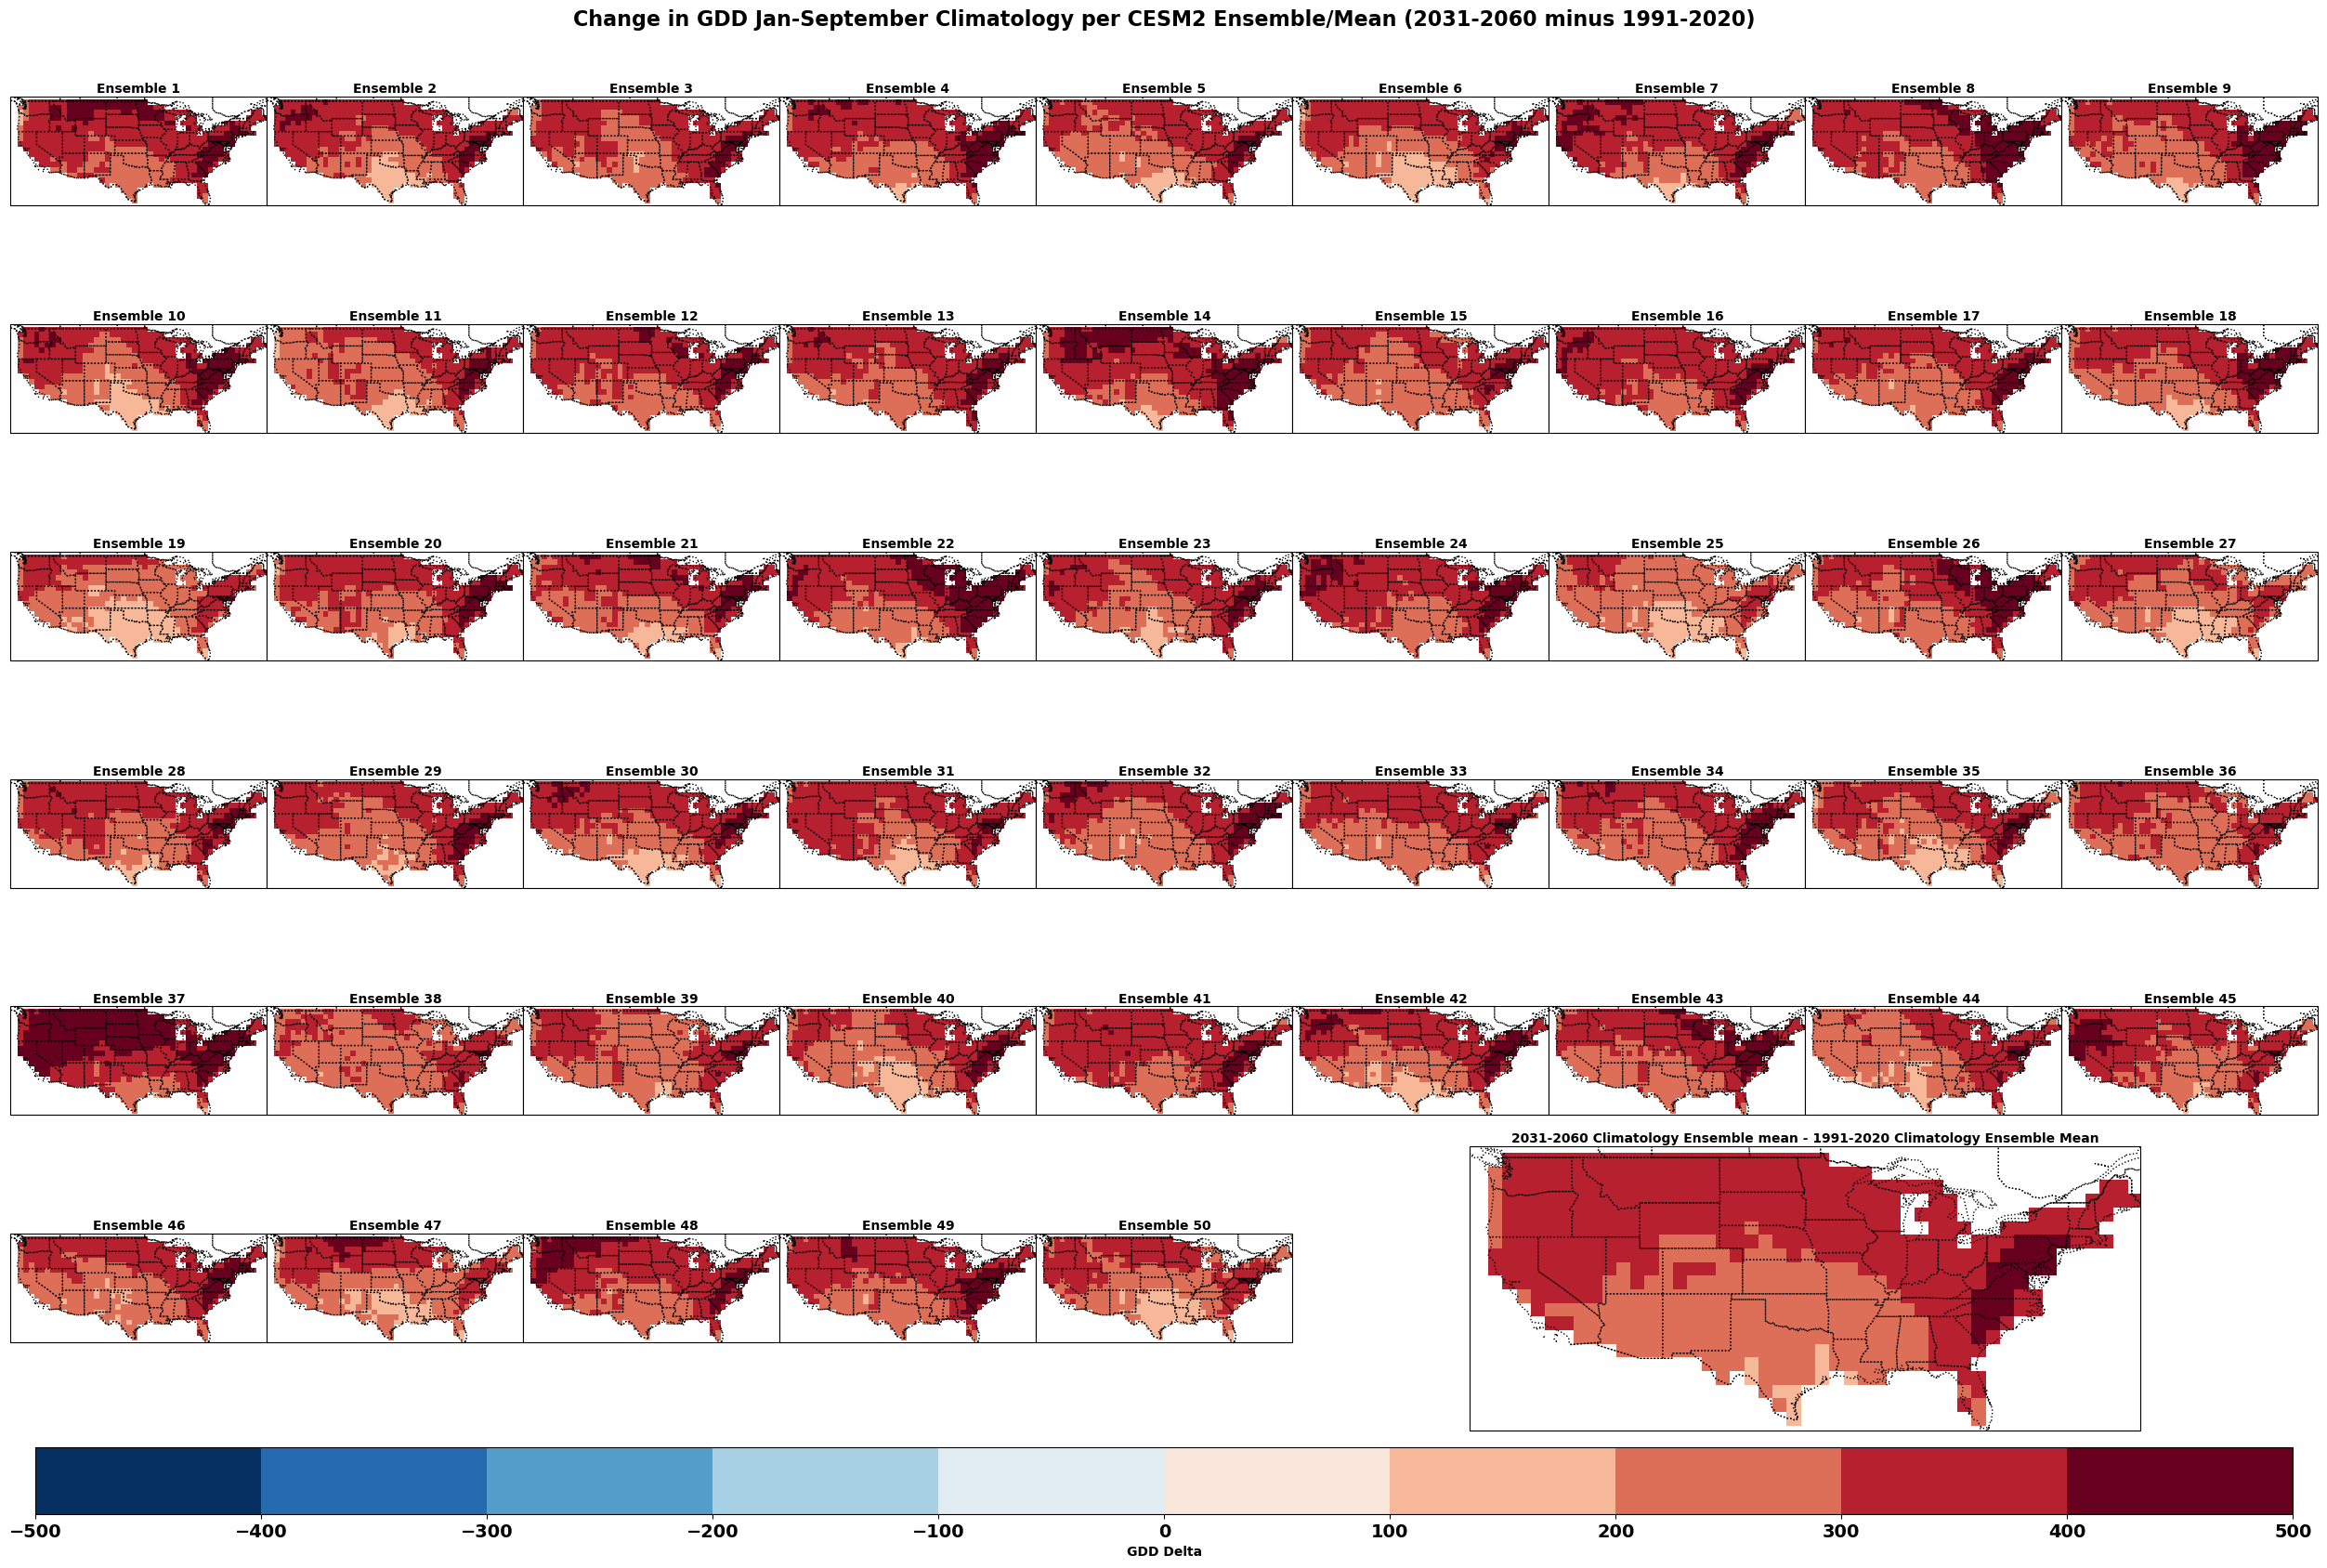

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import matplotlib as mpl
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import geopandas as gpd
import regionmask

# Load the data from NetCDF files
ds_1991_2020 = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/GDD_1991_2020.nc')
ds_2031_2060 = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/GDD_2031_2060.nc')


# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = ds_1991_2020['lon'].values  # Use .values to get a numpy array
lat_1d = ds_1991_2020['lat'].values

mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)


# Extract the GDD values for each ensemble member
gdd_1991_2020_ensemble = ds_1991_2020['gdd_ensemble_1991_2020']
gdd_2031_2060_ensemble = ds_2031_2060['gdd_ensemble_2031_2060']  
# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = ds_1991_2020['lon'].values  # Use .values to get a numpy array
lat_1d = ds_1991_2020['lat'].values

# Calculate the change (delta GDD) for each ensemble member
delta_gdd_ensemble_members = gdd_2031_2060_ensemble - gdd_1991_2020_ensemble

# Extract the ensemble mean GDD values
ensemble_mean_1991_2020 = ds_1991_2020['gdd_ensemble_mean_1991_2020']
ensemble_mean_2031_2060 = ds_2031_2060['gdd_ensemble_mean_2031_2060'] 

# Calculate the change (delta GDD) for the ensemble mean
delta_gdd_ensemble_mean = ensemble_mean_2031_2060 - ensemble_mean_1991_2020

# Define the boundaries for the discrete intervals for the delta
boundaries = np.linspace(-500, 500, 11)  # Example boundaries for delta GDD
ticks = np.linspace(-500, 500, 11)  # Example ticks for delta GDD

# Create a diverging color map for the delta GDD
cmap = plt.get_cmap('RdBu_r', len(boundaries) - 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
# Define the boundaries for the discrete intervals for the delta of the ensemble mean
mean_boundaries = np.linspace(-500, 500, 11)  # Smaller range for ensemble mean delta GDD
mean_ticks = np.linspace(-500, 500, 11)  # Fewer ticks for ensemble mean delta GDD

# Create a color map and norm object for the ensemble members
member_cmap = plt.get_cmap('RdBu_r', len(mean_boundaries) - 1)
member_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

# Create a norm object for the ensemble mean
mean_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

nrows, ncols = 6, 9
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'wspace':0, 'hspace':-0.2})  # Adjusted hspace for minimal spacing

# Loop over the axes and create the maps for the first 50 ensembles
for i, ax in enumerate(axes.flat[:50]):
    ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    
    delta_gdd = delta_gdd_ensemble_members[i] / 30
    delta_gdd_masked = np.where(mask == 0, delta_gdd, np.nan)
    
    pcm = ax.pcolormesh(lon_1d, lat_1d, delta_gdd_masked, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    #cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
    #cbar.ax.tick_params(labelsize=8)
    ax.set_title(f'Ensemble {i + 1}', fontsize=10, pad=3, weight='bold')

# Remove all axes after the 50 plots of ensembles
for ax in axes.flat[50:]:
    ax.remove()
start_col_for_mean = ncols - 4  # if you want it to span 5 columns
colspan_for_mean = 4  # the actual number of columns to span

# Use ncols in the place of 10 for colspan when you're spanning all columns.
ensemble_mean_change_ax = plt.subplot2grid(
    (nrows, ncols), 
    (nrows - 1, start_col_for_mean), 
    colspan=colspan_for_mean, 
    projection=ccrs.PlateCarree())

ensemble_mean_change_ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
ensemble_mean_change_ax.add_feature(cfeature.BORDERS, linestyle=':')
ensemble_mean_change_ax.add_feature(cfeature.STATES, linestyle=':')
delta_gdd_mean_masked = np.where(mask == 0, delta_gdd_ensemble_mean, np.nan)

pcm_mean = ensemble_mean_change_ax.pcolormesh(
    lon_1d, 
    lat_1d, 
    delta_gdd_mean_masked, 
    transform=ccrs.PlateCarree(), 
    cmap=member_cmap, 
    norm=mean_norm
)

ensemble_mean_change_ax.set_title('2031-2060 Climatology Ensemble mean - 1991-2020 Climatology Ensemble Mean', fontsize=10, pad=3, weight='bold')

# Set the subplot titles and add the gridlines only to the edge subplots
for i, ax in enumerate(axes.flat):
    if i < 50:
        ax.set_title(f'Ensemble {i + 1}', fontsize=10, pad=3, weight='bold')
    else:
        ax.set_visible(False)

# Create the colorbar for the ensemble mean with its unique boundaries and ticks
cbar_ax = fig.add_axes([0.05, 0.1, 0.9, 0.04])  # This will stretch the colorbar across the figure
cbar = fig.colorbar(pcm_mean, cax=cbar_ax, orientation='horizontal', 
                    boundaries=boundaries, ticks=ticks)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('GDD Delta',weight = 'bold')
# Bold the tick labels
for label in cbar.ax.get_xticklabels():
    label.set_fontweight('bold')

# Set latitude and longitude labels for the leftmost and bottom subplots only
for ax in axes.flat[::ncols]:  # the leftmost column
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=6, which='both', labelleft=True, labelright=False)

for ax in axes.flat[-ncols:]:  # the bottom row
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.tick_params(labelsize=6, which='both', labelbottom=True, labeltop=False)


# Adjust subplot_adjust to further fine-tune if necessary
plt.subplots_adjust(top=1, bottom=0.15, left=0.04, right=0.96)  # Adjust margins
plt.suptitle('Change in GDD Jan-September Climatology per CESM2 Ensemble/Mean (2031-2060 minus 1991-2020)', 
             fontsize=16, weight='bold', y=1)

plt.savefig('changeinGDDCESM2.png', dpi = 300, bbox_inches = 'tight')
# Show or save the figure
plt.show()


# Saving the arrays to a .nc file for both climatologies/ensemble means and differences

In [115]:
import xarray as xr

# Assuming `lat_1d` and `lon_1d` are the latitude and longitude arrays that match your GDD results

# Stack the list of numpy arrays along a new 'ensemble' dimension
gdd_1991_2020_da = xr.DataArray(data=np.stack(gdd_1991_2020_results),
                                dims=["ensemble", "lat", "lon"],
                                coords={"ensemble": np.arange(len(gdd_1991_2020_results)),
                                        "lat": lat_1d, "lon": lon_1d},
                                name='gdd_ensemble_1991_2020')

gdd_2031_2060_da = xr.DataArray(data=np.stack(gdd_2031_2060_results),
                                dims=["ensemble", "lat", "lon"],
                                coords={"ensemble": np.arange(len(gdd_2031_2060_results)),
                                        "lat": lat_1d, "lon": lon_1d},
                                name='gdd_ensemble_2031_2060')

# Convert ensemble means to DataArrays
ensemble_mean_1991_2020_da = xr.DataArray(data=ensemble_mean,
                                           dims=["lat", "lon"],
                                           coords={"lat": lat_1d, "lon": lon_1d},
                                           name='gdd_ensemble_mean_1991_2020')

ensemble_mean_2031_2060_da = xr.DataArray(data=ensemble_mean_2031_2060,
                                           dims=["lat", "lon"],
                                           coords={"lat": lat_1d, "lon": lon_1d},
                                           name='gdd_ensemble_mean_2031_2060')

# Create Xarray Datasets with descriptive variable names
ds_1991_2020 = xr.Dataset({"gdd_ensemble_1991_2020": gdd_1991_2020_da,
                           "gdd_ensemble_mean_1991_2020": ensemble_mean_1991_2020_da})

ds_2031_2060 = xr.Dataset({"gdd_ensemble_2031_2060": gdd_2031_2060_da,
                           "gdd_ensemble_mean_2031_2060": ensemble_mean_2031_2060_da})

# Save the Datasets to NetCDF files
output_path_1991_2020 = "/home/shawn_preston/gddcdesm2jansept/GDD_1991_2020.nc"
output_path_2031_2060 = "/home/shawn_preston/gddcdesm2jansept/GDD_2031_2060.nc"

ds_1991_2020.to_netcdf(output_path_1991_2020)
ds_2031_2060.to_netcdf(output_path_2031_2060)


# Starting process to save yearly gdd values so we can do a standard deviation analysis for 1991-2020

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import cftime

def calculate_annual_gdd(data, baseline=6, max_threshold=28):
    """Calculate annual Growing Degree Days (GDD) with specified baseline and max threshold."""
    # Ensure data does not exceed max threshold and is above the baseline
    # Using .where to keep the dataset structure including the time coordinate
    gdd = data.where(data > baseline, 0)
    gdd = gdd.where(gdd < max_threshold, max_threshold)
    gdd = gdd - baseline
    
    # Sum over each year to get annual GDD
    annual_gdd = gdd.groupby('time.year').sum('time')
    return annual_gdd

def filter_months(data, start_month=1, end_month=9):
    """Filter data to include only the months from January to September."""
    # Filter based on the month of the time coordinate
    return data.sel(time=data.time.dt.month.isin(range(start_month, end_month + 1)))

def process_file_yearly(file_path, start_year, end_year):
    """Process a single NetCDF file to calculate yearly GDD."""
    # Load the dataset
    ds = xr.open_dataset(file_path, use_cftime=True)
    # Convert TREFHT from Kelvin to Celsius and adjust for CONUS
    trefht_celsius = ds['TREFHT'].sel(lon=slice(235, 295), lat=slice(25, 50)) - 273.15
    
    # Filter data to only include January-September for each year
    conus_data = filter_months(trefht_celsius)
    
    # Calculate yearly GDD for the specified range of years
    annual_gdd = calculate_annual_gdd(conus_data)
    annual_gdd = annual_gdd.sel(year=slice(start_year, end_year))
    
    return annual_gdd

# Path to the .nc files
nc_files_directory = '/data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/*.nc'
nc_files = glob.glob(nc_files_directory)
nc_files.sort()

# Define the period of interest
start_year = 1991
end_year = 2020

# Process each file and save the results
for file_idx, file_path in enumerate(nc_files):
    print(f"Processing {file_path}")
    yearly_gdd = process_file_yearly(file_path, start_year, end_year)
    
    # Construct the output file name based on the input file
    output_file_name = f'/home/shawn_preston/gddcdesm2jansept/yearly_gdd_1991_2020_ensemble_member_{file_idx+1}.nc'
    print(f"Saving to {output_file_name}")
    yearly_gdd.to_netcdf(output_file_name)


Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1001_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_1991_2020_ensemble_member_1.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1021_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_1991_2020_ensemble_member_2.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1041_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_1991_2020_ensemble_member_3.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1061_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_1991_2020_ensemble_member_4.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1081_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_1991_2020_ensemble_member_5.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_

# This is to create the yearly gdd for 2031-2060 

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import cftime

def calculate_annual_gdd(data, baseline=6, max_threshold=28):
    """Calculate annual Growing Degree Days (GDD) with specified baseline and max threshold."""
    # Ensure data does not exceed max threshold and is above the baseline
    # Using .where to keep the dataset structure including the time coordinate
    gdd = data.where(data > baseline, 0)
    gdd = gdd.where(gdd < max_threshold, max_threshold)
    gdd = gdd - baseline
    
    # Sum over each year to get annual GDD
    annual_gdd = gdd.groupby('time.year').sum('time')
    return annual_gdd

def filter_months(data, start_month=1, end_month=9):
    """Filter data to include only the months from January to September."""
    # Filter based on the month of the time coordinate
    return data.sel(time=data.time.dt.month.isin(range(start_month, end_month + 1)))

def process_file_yearly(file_path, start_year, end_year):
    """Process a single NetCDF file to calculate yearly GDD."""
    # Load the dataset
    ds = xr.open_dataset(file_path, use_cftime=True)
    # Convert TREFHT from Kelvin to Celsius and adjust for CONUS
    trefht_celsius = ds['TREFHT'].sel(lon=slice(235, 295), lat=slice(25, 50)) - 273.15
    
    # Filter data to only include January-September for each year
    conus_data = filter_months(trefht_celsius)
    
    # Calculate yearly GDD for the specified range of years
    annual_gdd = calculate_annual_gdd(conus_data)
    annual_gdd = annual_gdd.sel(year=slice(start_year, end_year))
    
    return annual_gdd

# Path to the .nc files
nc_files_directory = '/data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/*.nc'
nc_files = glob.glob(nc_files_directory)
nc_files.sort()

# Define the period of interest
start_year = 2031
end_year = 2060

# Process each file and save the results
for file_idx, file_path in enumerate(nc_files):
    print(f"Processing {file_path}")
    yearly_gdd = process_file_yearly(file_path, start_year, end_year)
    
    # Construct the output file name based on the input file
    output_file_name = f'/home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_{file_idx+1}.nc'
    print(f"Saving to {output_file_name}")
    yearly_gdd.to_netcdf(output_file_name)


Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1001_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_1.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1021_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_2.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1041_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_3.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1061_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_4.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_1081_concatenated.nc
Saving to /home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_5.nc
Processing /data/project/agaid/singh_cesm_ts/cesm_ts_concatenated/ensemble_

In [20]:
import xarray as xr
ds = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/yearly_gdd_2031_2060_ensemble_member_18.nc')
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 26, lon: 49, year: 30)
Coordinates:
  * lat      (lat) float64 25.92 26.86 27.8 28.74 ... 46.65 47.59 48.53 49.48
  * lon      (lon) float64 235.0 236.2 237.5 238.8 ... 291.2 292.5 293.8 295.0
  * year     (year) int64 2031 2032 2033 2034 2035 ... 2056 2057 2058 2059 2060
Data variables:
    TREFHT   (year, lat, lon) float32 ...


In [8]:
import geopandas as gpd

# Load the shapefile
shapefile_path = '/home/shawn_preston/shapefile_nation/combined_conus.shp'
gdf = gpd.read_file(shapefile_path)

# Print the GeoDataFrame's columns and the first few rows
print(gdf.columns)
print(gdf.head())


Index(['FID', 'geometry'], dtype='object')
   FID                                           geometry
0    0  MULTIPOLYGON (((278.18831 24.56874, 278.24873 ...
